In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import itertools
import random
import copy
from pprint import pprint

In [4]:
list(itertools.product(range(5),range(3)))

[(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2),
 (4, 0),
 (4, 1),
 (4, 2)]

In [18]:
x = list(range(20))
x[:11:3]


list

In [19]:
class Schelling:
    def __init__(self, width, height, empty_ratio, similarity_threshold, n_iterations, races = 2):
        self.width = width 
        self.height = height 
        self.races = races
        self.empty_ratio = empty_ratio
        self.similarity_threshold = similarity_threshold
        self.n_iterations = n_iterations
        self.empty_houses = []
        self.agents = {}
        
    def populate(self) :
        # product returns all combos of range(width) with range(height)--it's our grid.
        self.all_houses = list(itertools.product(range(self.width),range(self.height)))
        
        # shuffle the houses so that they are filled randomly.
        random.shuffle(self.all_houses)

        self.n_empty = int( self.empty_ratio * len(self.all_houses) )
        self.empty_houses = self.all_houses[:self.n_empty] #  n_empty are designated as empty.

        self.remaining_houses = self.all_houses[self.n_empty:]
        houses_by_race = [self.remaining_houses[i::self.races] for i in range(self.races)]
        # houses_by_race is a list of agents (denoted by the x,y pairs) with a list
        # for each race. This clever use of step-size in slice is a nice shortcut.
        
        self.agents = dict()

        for i in range(self.races) :
            for agent in houses_by_race[i] :
                self.agents[agent] = i+1 # race is marked by the number i+1
        
        # at this point self.agents is a dictionary where the key is an x,y
        # pair and the value is a list with value are i+1.
                
    def is_unsatisfied(self, x, y) :
        race = self.agents[(x,y)]
        count_similar = 0
        count_different = 0

        # No easy way that I could think of to count up the similar neighbors.
        # Let's brute force it.
        if x > 0 and y > 0 and (x-1, y-1) not in self.empty_houses:
            if self.agents[(x-1, y-1)] == race:
                count_similar += 1
            else:
                count_different += 1
        if y > 0 and (x,y-1) not in self.empty_houses:
            if self.agents[(x,y-1)] == race:
                count_similar += 1
            else:
                count_different += 1
        if x < (self.width-1) and y > 0 and (x+1,y-1) not in self.empty_houses:
            if self.agents[(x+1,y-1)] == race:
                count_similar += 1
            else:
                count_different += 1
        if x > 0 and (x-1,y) not in self.empty_houses:
            if self.agents[(x-1,y)] == race:
                count_similar += 1
            else:
                count_different += 1        
        if x < (self.width-1) and (x+1,y) not in self.empty_houses:
            if self.agents[(x+1,y)] == race:
                count_similar += 1
            else:
                count_different += 1
        if x > 0 and y < (self.height-1) and (x-1,y+1) not in self.empty_houses:
            if self.agents[(x-1,y+1)] == race:
                count_similar += 1
            else:
                count_different += 1        
        if x > 0 and y < (self.height-1) and (x,y+1) not in self.empty_houses:
            if self.agents[(x,y+1)] == race:
                count_similar += 1
            else:
                count_different += 1        
        if x < (self.width-1) and y < (self.height-1) and (x+1,y+1) not in self.empty_houses:
            if self.agents[(x+1,y+1)] == race:
                count_similar += 1
            else:
                count_different += 1

        if (count_similar+count_different) == 0:
            return False
        else:
            return float(count_similar)/(count_similar+count_different) < self.similarity_threshold
        
    def update(self):
        for i in range(self.n_iterations):
            # nested structures require "deepcopy" to make an actual copy, 
            # as opposed to just making a reference.
            self.old_agents = copy.deepcopy(self.agents)
            n_changes = 0
            for agent in self.old_agents:
                if self.is_unsatisfied(agent[0], agent[1]): # agent[0] is x, agent[1] is y
                    agent_race = self.agents[agent]
                    empty_house = random.choice(self.empty_houses)
                    self.agents[empty_house] = agent_race
                    del self.agents[agent] # empty out the spot for this agent.
                    self.empty_houses.remove(empty_house) # mark their new spot as not-empty
                    self.empty_houses.append(agent) # and put the agent there.
                    n_changes += 1
            print(n_changes)
            if n_changes == 0:
                break

    def move_to_empty(self, x, y):
        race = self.agents[(x,y)]
        empty_house = random.choice(self.empty_houses)
        self.updated_agents[empty_house] = race
        del self.updated_agents[(x, y)]
        self.empty_houses.remove(empty_house)
        self.empty_houses.append((x, y))

    def plot(self, title, file_name=None):
        fig, ax = plt.subplots()
        #If you want to run the simulation with more than 7 colors, you should set agent_colors accordingly
        agent_colors = {1:'b', 2:'r', 3:'g', 4:'c', 5:'m', 6:'y', 7:'k'}
        for agent in self.agents:
            ax.scatter(agent[0]+0.5, agent[1]+0.5, color=agent_colors[self.agents[agent]])

        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlim([0, self.width])
        ax.set_ylim([0, self.height])
        ax.set_xticks([])
        ax.set_yticks([])
        if file_name :
            plt.savefig(file_name)
        else :
            plt.show()
        
    def calculate_similarity(self):
        ''' used to measure the overall similarity of a system. This is useful when we 
            are trying to study the impact of things like empty space or similarty_threshold. '''
        similarity = []
        for agent in self.agents:
            count_similar = 0
            count_different = 0
            x = agent[0]
            y = agent[1]
            race = self.agents[(x,y)]
            if x > 0 and y > 0 and (x-1, y-1) not in self.empty_houses:
                if self.agents[(x-1, y-1)] == race:
                    count_similar += 1
                else:
                    count_different += 1
            if y > 0 and (x,y-1) not in self.empty_houses:
                if self.agents[(x,y-1)] == race:
                    count_similar += 1
                else:
                    count_different += 1
            if x < (self.width-1) and y > 0 and (x+1,y-1) not in self.empty_houses:
                if self.agents[(x+1,y-1)] == race:
                    count_similar += 1
                else:
                    count_different += 1
            if x > 0 and (x-1,y) not in self.empty_houses:
                if self.agents[(x-1,y)] == race:
                    count_similar += 1
                else:
                    count_different += 1        
            if x < (self.width-1) and (x+1,y) not in self.empty_houses:
                if self.agents[(x+1,y)] == race:
                    count_similar += 1
                else:
                    count_different += 1
            if x > 0 and y < (self.height-1) and (x-1,y+1) not in self.empty_houses:
                if self.agents[(x-1,y+1)] == race:
                    count_similar += 1
                else:
                    count_different += 1        
            if x > 0 and y < (self.height-1) and (x,y+1) not in self.empty_houses:
                if self.agents[(x,y+1)] == race:
                    count_similar += 1
                else:
                    count_different += 1        
            if x < (self.width-1) and y < (self.height-1) and (x+1,y+1) not in self.empty_houses:
                if self.agents[(x+1,y+1)] == race:
                    count_similar += 1
                else:
                    count_different += 1
            try:
                similarity.append(float(count_similar)/(count_similar+count_different))
            except:
                similarity.append(1)
        return sum(similarity)/len(similarity)

302
153
103
48
18
7
5
1
1
1
1
0


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


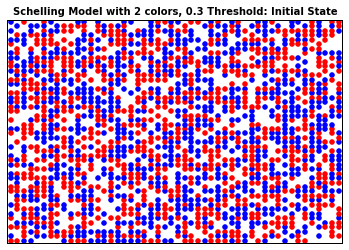

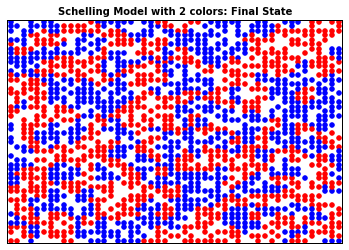

In [20]:
# Let's do a version with just 2 colors
schelling_2 = Schelling(50, 50, # grid size
                        0.3, # empty ratio 
                        0.3, # similarity threshold
                        500, # max number of iterations used in .update 
                        2) # number of races
schelling_2.populate()
schelling_2.plot('Schelling Model with 2 colors, 0.3 Threshold: Initial State',"schelling_thresh3_race2_start.png")

# Now let's call update and plot the results.
schelling_2.update()
schelling_2.plot("Schelling Model with 2 colors: Final State","schelling_thresh3_race2_final.png")

1320
1039
806
646
536
477
386
332
291
244
199
161
161
129
101
87
62
53
46
36
25
19
15
19
19
17
8
4
5
1
1
1
0


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


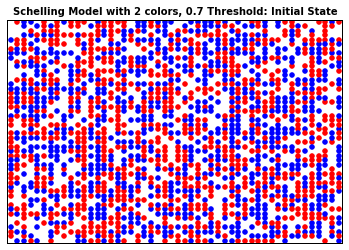

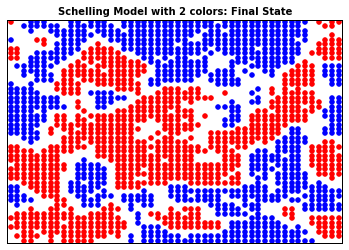

In [21]:
# Let's do a version with just 2 colors
schelling_2 = Schelling(50, 50, # grid size
                        0.3, # empty ratio 
                        0.7, # similarity threshold
                        800, # max number of iterations used in .update 
                        2) # number of racesn
schelling_2.populate()
schelling_2.plot('Schelling Model with 2 colors, 0.7 Threshold: Initial State',"schelling_thresh7_race2_start.png")

# Now let's call update and plot the results.
schelling_2.update()
schelling_2.plot("Schelling Model with 2 colors: Final State","schelling_thresh7_race2_final.png")

In [22]:
schelling_2.calculate_similarity()

0.9943809523809519

In [ ]:
schelling_3 = Schelling(50, 50, 0.2, 0.6, 500, 3)
schelling_3.populate()
schelling_3.plot('Schelling Model with 3 colors: Initial State')

In [ ]:
schelling_3.update()

schelling_3.plot('Schelling Model with 3 colors: Final State') #, 'schelling_3_final.png')

In [ ]:
similarity_threshold_ratio = {}
for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8]:
    schelling = Schelling(50, 50, 0.3, i, 500, 2)
    schelling.populate()
    schelling.update()
    similarity_threshold_ratio[i] = schelling.calculate_similarity()

In [ ]:
fig, ax = plt.subplots()
plt.plot(list(similarity_threshold_ratio.keys()), list(similarity_threshold_ratio.values()), 'ro')
ax.set_title('Similarity Threshold vs. Mean Similarity Ratio', fontsize=15, fontweight='bold')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.1])
ax.set_xlabel("Similarity Threshold")
ax.set_ylabel("Mean Similarity Ratio")
#plt.show()
plt.savefig('schelling_segregation_measure.png')